In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from numpy import linalg
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")


**Data Preparation**

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ratings.csv")

In [ ]:
pivot_table = df.pivot(index='movieId', columns='userId', values='rating')

In [ ]:
index = pivot_table.index.values
df51  = pivot_table.reset_index()
df51.set_index(index,inplace=True)
df51.drop(columns=["movieId"], inplace=True)

In [ ]:
df2 = pd.read_csv("/content/drive/MyDrive/movies.csv", delimiter = ";", na_values=["(no genres listed)","nan"])

movieId = df2["movieId"]
df2.drop(columns=["movieId", "title"], inplace=True)

movieId = movieId[df2.isnull().sum(axis=1) != 10]
df2.dropna(axis=0, how="all", inplace=True)

In [ ]:
df2;

In [ ]:
df2.to_csv('final_movieID.csv', index=True)

In [ ]:
coeff = 1/df2.notna().sum(axis=1)

coeff = coeff*df2.notna().sum(axis=1)

In [ ]:
cols = [i for i in df2.iloc[:,0:].columns]
tmp = pd.melt(df2.reset_index() ,id_vars = ['index'], value_vars = cols )
tmp['coeff'] = 1
df4 = pd.pivot_table(tmp, values = 'coeff', index = 'index', columns = 'value')

In [ ]:
for i in range (0,len(df4)):
    df4.iloc[i].replace(1, coeff.iloc[i], inplace=True)
df4.fillna(0,inplace=True)

In [ ]:
df5 = df4.reset_index()
df5.drop(columns=["index"], inplace=True)
df6 = pd.DataFrame()
for i in df5:
    df6[i] = df5[i]
df6.set_index(movieId, inplace=True)

In [ ]:
df_final = df51.join(df6, how="inner")

In [ ]:
features_header = df6.columns
features = df_final[features_header]
features.insert(loc=0, column='x0', value=1)
ratings  = df_final.drop(columns = features_header)

In [ ]:
ratings;

In [ ]:
df_final;

In [ ]:
features;

## Explotary Data Analysis

In [ ]:
features_new = features.drop(columns=['x0'])
cat_df = pd.DataFrame(columns=['Category', 'Number of Occurrences'])
for i in features_new:
  nonzero_count = np.count_nonzero(features_new[i])
  cat_df = cat_df.append({'Category': i, 'Number of Occurrences': nonzero_count}, ignore_index=True)

print(cat_df)
total_nonzero_count = np.sum(np.count_nonzero(features_new))
print("Total category occurences:",total_nonzero_count)

       Category Number of Occurrences
0        Action                  1737
1     Adventure                  1164
2     Animation                   400
3      Children                   540
4        Comedy                  3513
5         Crime                  1440
6   Documentary                   415
7         Drama                  5218
8       Fantasy                   670
9     Film-Noir                   195
10       Horror                  1001
11         IMAX                   152
12      Musical                   409
13      Mystery                   675
14      Romance                  1788
15       Sci-Fi                   859
16     Thriller                  2187
17          War                   503
18      Western                   235
Total category occurences: 23101


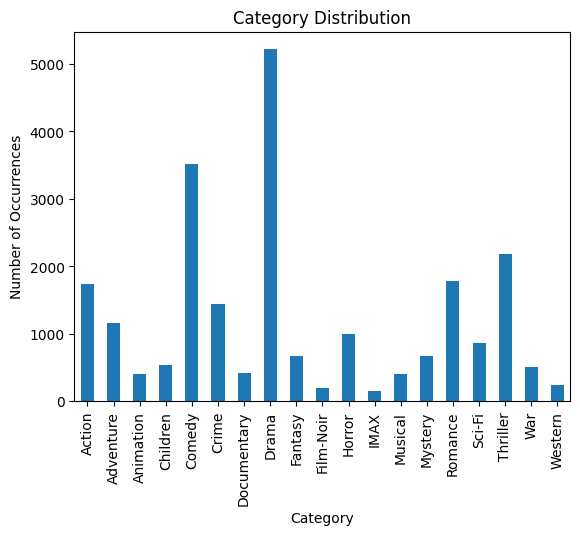

In [ ]:
ax = cat_df.plot.bar(legend=False)
ax.set_xticklabels(cat_df['Category'], rotation=90)

plt.title('Category Distribution');
plt.xlabel('Category');
plt.ylabel('Number of Occurrences');


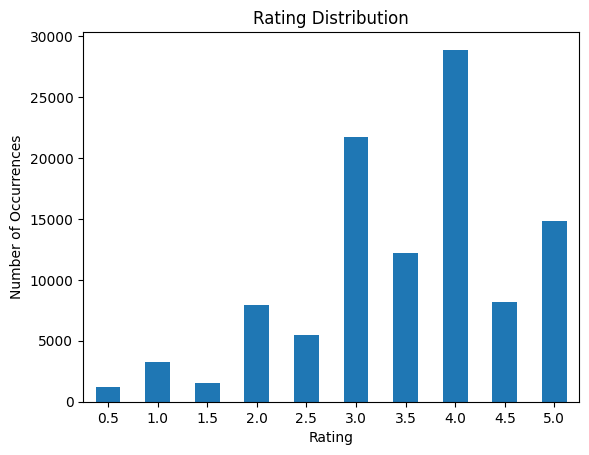

Average rating is: 3.5168799605058294


In [ ]:
category_counts = ratings.stack().value_counts().sort_index()

ax = category_counts.plot.bar(legend=None)

ax.set_xticklabels(category_counts.index, rotation=0)

plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Number of Occurrences')

plt.show()

print("Average rating is:",ratings.stack().mean())

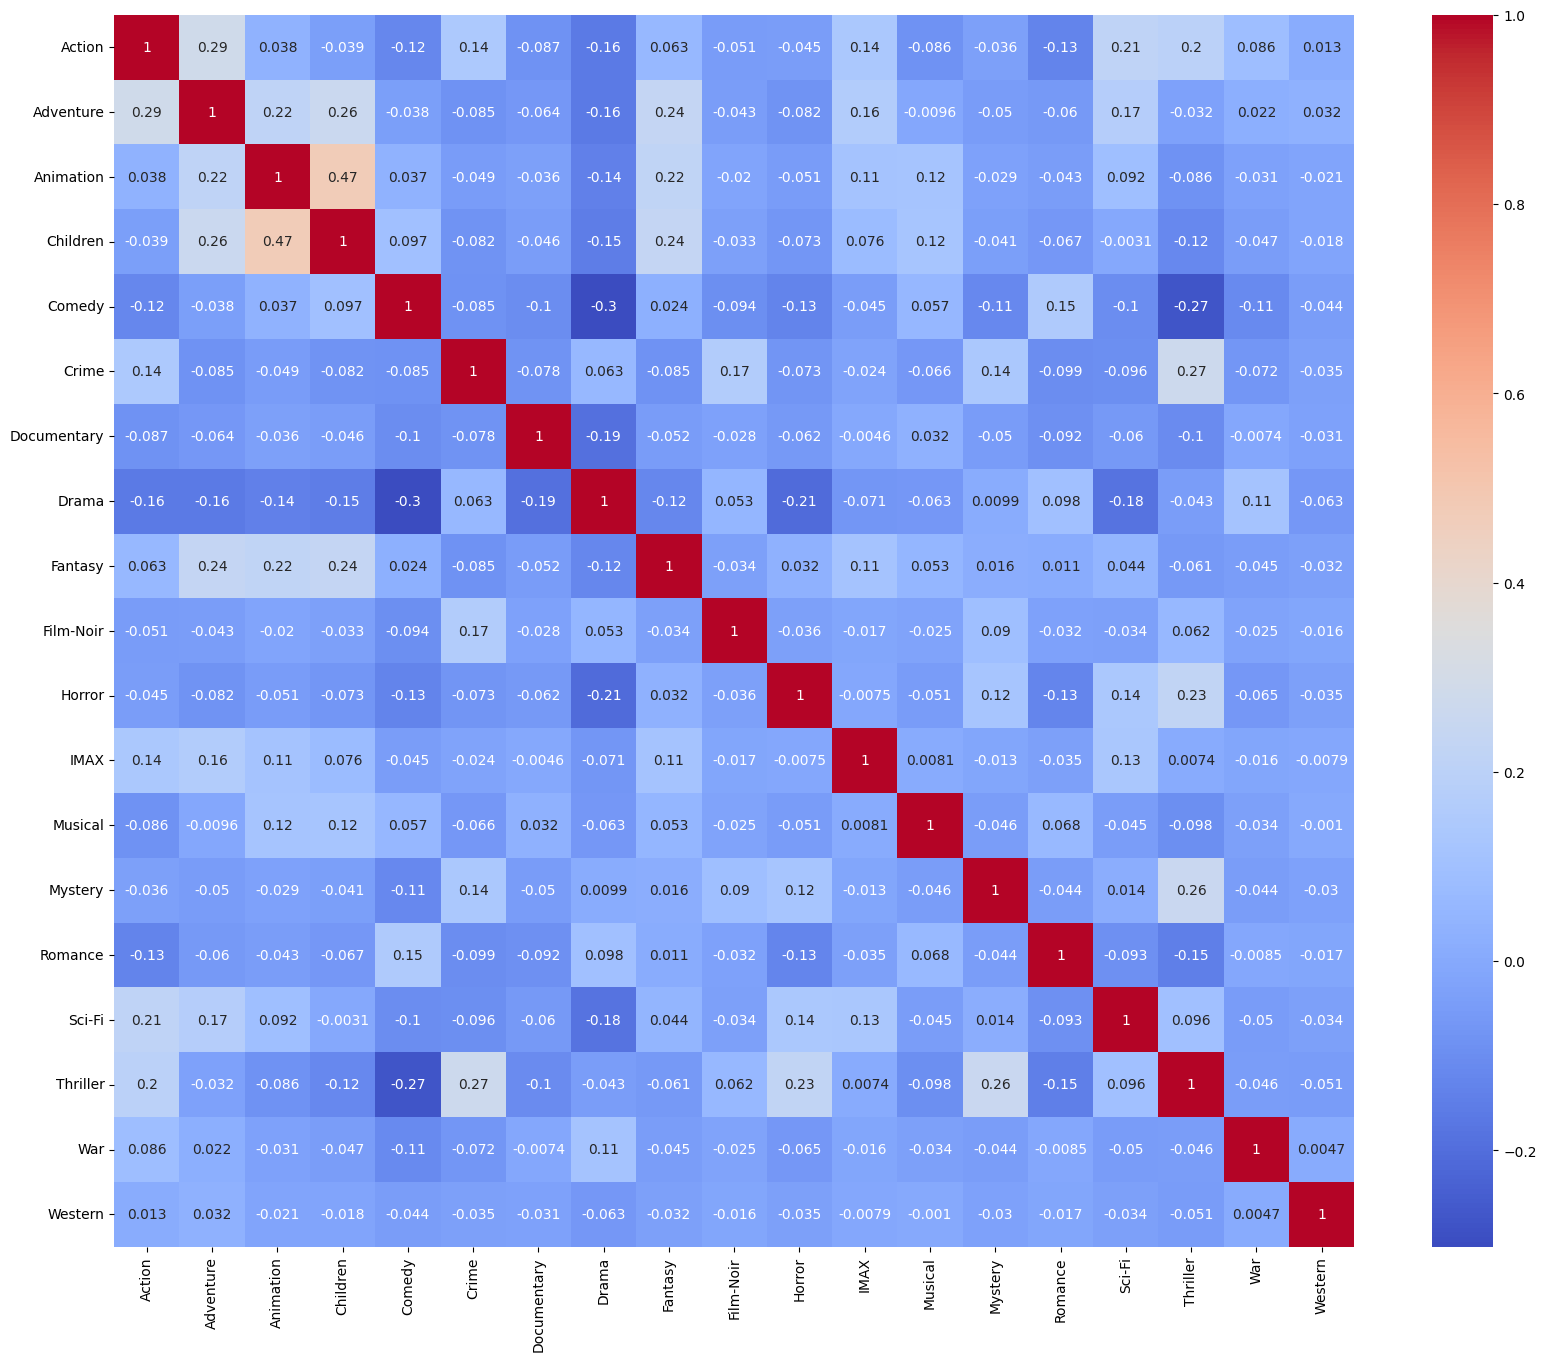

In [ ]:
corr_matrix = features_new.corr()
plt.figure(figsize=(20, 16));
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True);

In [ ]:
final_data = pd.read_csv("/content/drive/MyDrive/final_data.csv")
final_data.drop(columns=["Unnamed: 0"],inplace=True)

(20, 35]        151
(35, 50]         78
(50, 75]        103
(75, 100]        64
(100, 200]      121
(200, 400]       81
(400, 800]       31
(800, 1600]      17
(1600, 3200]      2
(3200, 6400]      1
Name: UserId, dtype: int64
Mean rating count: 157.68263473053892


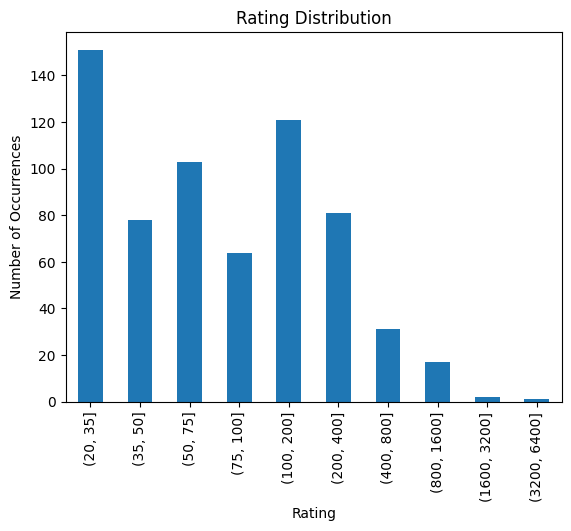

In [ ]:
user_ratings_counts = final_data['UserId'].value_counts()
mean_rating_count = user_ratings_counts.mean()

bins = [20,35, 50, 75, 100, 200, 400,800,1600,3200,6400]

rating_ranges = pd.cut(user_ratings_counts, bins=bins)

counts = rating_ranges.value_counts().sort_index()
print(counts)

ax = counts.plot.bar(legend=None)

ax.set_xticklabels(counts.index, rotation=90)

plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Number of Occurrences')

print("Mean rating count:",mean_rating_count)


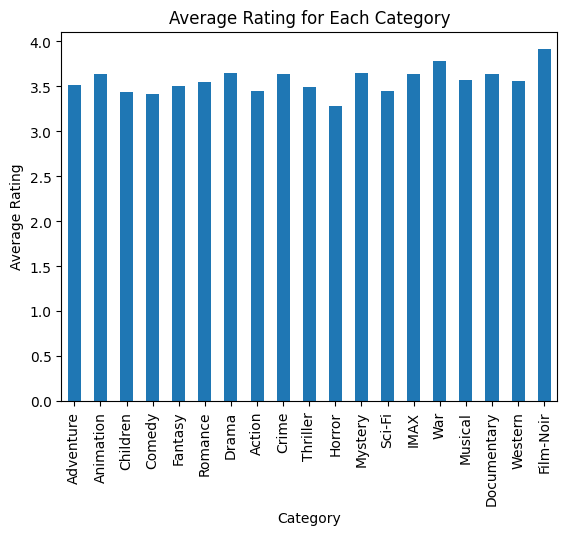

In [ ]:
category_ratings = final_data.drop(columns=['UserId','MovieId'])

cat_rating_df = pd.DataFrame(columns=['Category', 'Average Rating'])
for i in category_ratings:
  cat_rating = category_ratings[category_ratings[i]==1]['Rating'].mean()
  cat_rating_df = cat_rating_df.append({'Category': i, 'Average Rating': cat_rating}, ignore_index=True)

cat_rating_df = cat_rating_df.drop(index=19)

ax = cat_rating_df.plot.bar(legend=None)

ax.set_xticklabels(cat_rating_df['Category'], rotation=90)

plt.title('Average Rating for Each Category');
plt.xlabel('Category');
plt.ylabel('Average Rating');

In [ ]:
import re
movie_df = pd.read_csv("/content/drive/MyDrive/movies.csv", delimiter = ";", na_values=["(no genres listed)","nan"])
year_pattern = re.compile(r'\((\d{4})\)')
def extract_year(x):
    match = year_pattern.search(x)
    if match:
        return match.group(1)
    else:
        return None
movie_df['year'] = movie_df['title'].apply(extract_year)
movie_df['index'] = movie_df.index
movie_id_year = movie_df[['movieId','year']]
movie_id_year = movie_id_year.rename(columns={'movieId': 'MovieId'})
movie_id_year['year'] = pd.to_numeric(movie_id_year['year'] , errors='coerce')
movie_id_year = movie_id_year.dropna()
merged_df = pd.merge(final_data, movie_id_year, on='MovieId')
merged_df['normalized_year'] = (merged_df['year'] - merged_df['year'].mean()) / merged_df['year'].std()
final_merged_df = merged_df.drop(columns=["year"])

In [ ]:
final_merged_df

,UserId,MovieId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,...,Mystery,Sci-Fi,IMAX,War,Musical,Documentary,Western,Film-Noir,Rating,normalized_year
0,1,16,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,4.0,0.197729
1,9,16,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,4.0,0.197729
2,12,16,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1.5,0.197729
3,24,16,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,4.0,0.197729
4,29,16,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3.0,0.197729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105321,668,138914,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.5,-1.667427
105322,668,140098,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2.5,1.529984
105323,668,140816,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,2.5,1.529984
105324,668,142488,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4.0,1.529984


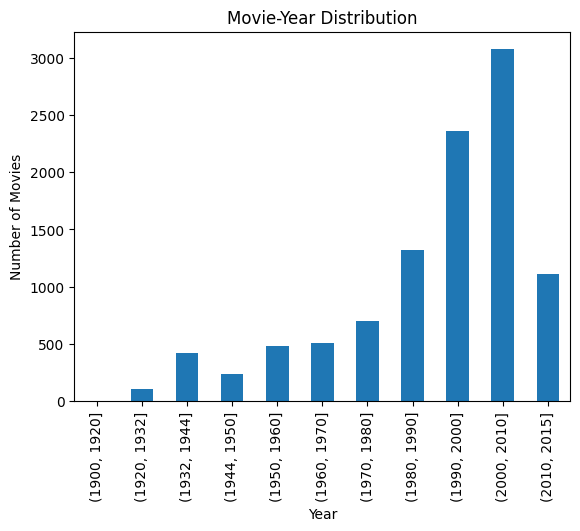

In [ ]:
bins = [1900, 1920, 1932, 1944, 1950, 1960, 1970, 1980, 1990, 2000, 2010,2015]

movie_id_year['bin_range'] = pd.cut(movie_id_year['year'], bins)

movie_count = movie_id_year.groupby('bin_range').size()

movie_count.plot(kind='bar')

plt.title('Movie-Year Distribution');
plt.xlabel('Year');
plt.ylabel('Number of Movies');

In [ ]:
movie_count

bin_range
(1900, 1920]       6
(1920, 1932]     106
(1932, 1944]     422
(1944, 1950]     240
(1950, 1960]     479
(1960, 1970]     512
(1970, 1980]     697
(1980, 1990]    1320
(1990, 2000]    2359
(2000, 2010]    3074
(2010, 2015]    1111
dtype: int64

## **Problem Formulation & Gradient Descent Algorithm**

In [ ]:
movie_df

,movieId,title,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,year,index
0,1,Toy Story (1995),Adventure,Animation,Children,Comedy,Fantasy,NaN,NaN,NaN,NaN,NaN,1995,0
1,2,Jumanji (1995),Adventure,Children,Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1995,1
2,3,Grumpier Old Men (1995),Comedy,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1995,2
3,4,Waiting to Exhale (1995),Comedy,Drama,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1995,3
4,5,Father of the Bride Part II (1995),Comedy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1995,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10324,146684,Cosmic Scrat-tastrophe (2015),Animation,Children,Comedy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,10324
10325,146878,Le Grand Restaurant (1966),Comedy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1966,10325
10326,148238,A Very Murray Christmas (2015),Comedy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,10326
10327,148626,The Big Short (2015),Drama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,10327


# Content-Based Approach

In [ ]:
#Hyperparameters
theta = np.full((668, 19), 0.05)
#ones_col = np.zeros((theta.shape[0], 1))
#theta = np.concatenate((ones_col, theta), axis=1)

x = features
y = ratings.T

lambda_val = 0.1
alpha = 0.01

In [ ]:
%%time
x_ridge = x.drop(columns=['x0'])
lamb_values = np.linspace(0.02, 1.02, num=50).tolist()
rmse_array = []
x_test = []
y_test = []
x_train = []
y_train = []
added = 0

for l in lamb_values:
  rmse_total = 0
  for j in range (668):
    non_empty_y_j = y.iloc[j].dropna()
    indexes = non_empty_y_j.index

    x_i_j = x_ridge.loc[indexes].values

    y_j = non_empty_y_j.values.reshape(non_empty_y_j.shape[0],1)
    identity_matrix = np.identity(19)

    x_train_val, x_test_j, y_train_val,y_test_j = train_test_split(x_i_j, y_j, test_size=0.3, random_state=42)
    if added == 0:
      x_test.append(np.array(x_test_j))
      y_test.append(np.array(y_test_j))
      x_train.append(np.array(x_train_val))
      y_train.append(np.array(y_train_val))

    k = 5

    perm = np.random.RandomState(seed=27).permutation(len(x_train_val))
    x_shuffled = x_train_val[perm]
    y_shuffled = y_train_val[perm]

    folds_x = np.array_split(x_shuffled, k)
    folds_y = np.array_split(y_shuffled, k)

    scores = []

    for i in range(k):
        val_set_x = folds_x[i]
        val_set_y = folds_x[i]

        train_sets_x = [f for j, f in enumerate(folds_x) if j != i]
        train_set_x = np.concatenate(train_sets_x, axis=0)

        train_sets_y = [f for j, f in enumerate(folds_y) if j != i]
        train_set_y = np.concatenate(train_sets_y, axis=0)

        b_rss_j = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(train_set_x),train_set_x)+ l*identity_matrix),np.transpose(train_set_x)),train_set_y)

        pred = val_set_x @ b_rss_j

        rmse = np.sqrt(np.sum(np.square(pred - val_set_y)))
        scores.append(rmse)

    rmse_mean_score = np.mean(scores)

    theta[j] = b_rss_j.flatten()
    if j ==667:
      added = 1

  rmse_total += rmse_mean_score
  rmse_array.append(rmse_total/668)

CPU times: user 2min 14s, sys: 4min 5s, total: 6min 20s
Wall time: 1min 45s


In [ ]:
min_index = rmse_array.index(min(rmse_array))
lamd = round(min_index*0.02+0.02,2)
print("Minimum RMSE on validation set for all users found for lambda:",lamd)

Minimum RMSE on validation set for all users found for lambda: 1.0


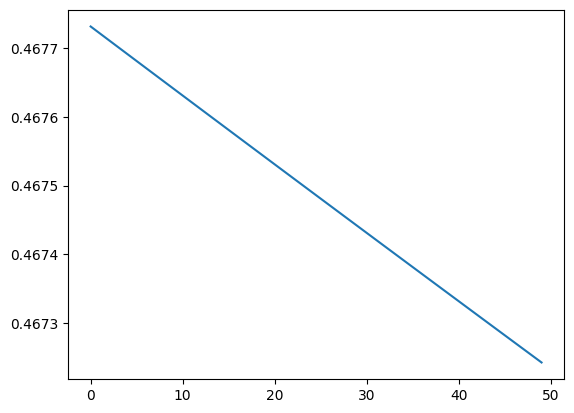

In [ ]:
plt.plot(rmse_array)

In [ ]:
rmse_test = 0
for j in range (668):
  x_test_j = x_test[j]
  y_test_j = y_test[j]
  x_train_j = x_train[j]
  y_train_j = y_train[j]

  identity_matrix = np.identity(19)

  b_rss_j = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(x_train_j),x_train_j)+ 1*identity_matrix),np.transpose(x_train_j)),y_train_j)

  pred = x_test_j @ b_rss_j

  rmse_test_j = np.sqrt(np.sum(np.square(pred - y_test_j)))

  theta[j] = b_rss_j.flatten()
  rmse_test_j_mean = rmse_test_j/len(pred)
  rmse_test += rmse_test_j_mean
print("RMSE on test data set:", round(rmse_test/668,2))


RMSE on test data set: 0.36


In [ ]:
np.shape(x_test)

(668,)

In [ ]:
print("Predicted :", np.dot(x_ridge.iloc[10311] , theta[667]))
print("Actual    :", y.iloc[667][144976])

Predicted : 2.5630042261447183
Actual    : 2.5


In [ ]:
prediction_matrix = np.dot(theta,x_ridge.T)

In [ ]:
print(np.shape(prediction_matrix))
prediction_matrix

(668, 10318)


array([[3.44376015, 2.23374622, 1.56910544, ..., 0.74260901, 0.74260901,
        1.71323465],
       [4.1734211 , 2.07912084, 1.98662419, ..., 1.45400721, 1.45400721,
        3.34317984],
       [1.69919614, 0.01486179, 2.79755279, ..., 2.02704715, 2.02704715,
        2.44865352],
       ...,
       [3.36803691, 1.73359917, 1.78531769, ..., 1.7334815 , 1.7334815 ,
        2.36679963],
       [4.39162119, 2.90455598, 2.49530658, ..., 1.16563716, 1.16563716,
        2.21457537],
       [3.30859424, 1.80122319, 1.76924038, ..., 1.19215798, 1.19215798,
        1.98153055]])

In [ ]:
movies_with_cluster = pd.read_csv('/content/drive/MyDrive/movies_clustered_final.csv')
movies_with_cluster


,MovieId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,...,Horror,Mystery,Sci-Fi,IMAX,War,Musical,Documentary,Western,Film-Noir,cluster_label
0,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,4,0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10317,146656,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,8
10318,146684,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
10319,146878,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
10320,148238,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [ ]:
movies_with_cluster = movies_with_cluster.rename(columns={'MovieId': 'movieId'})


In [ ]:
import numpy as np
import pandas as pd

def recommend_movies(user_id, ratings_df, prediction_matrix, movie_df, movies_with_cluster, n_recommendations=5):
    # Fetch the movieIds of movies rated by the user
    rated_movie_ids = ratings_df.columns[ratings_df.loc[user_id].notna()]

    # Fetch the movieIds of movies not rated by the user
    unrated_movie_ids = ratings_df.columns[ratings_df.loc[user_id].isna()]

    # Map the movieIds to their corresponding indices in the ratings matrix
    rated_movie_idxs = np.where(ratings_df.columns.isin(rated_movie_ids))
    unrated_movie_idxs = np.where(ratings_df.columns.isin(unrated_movie_ids))

    # Fetch the corresponding predicted ratings for the unrated movies from the prediction matrix
    unrated_predictions = pd.Series(prediction_matrix[user_id-1, unrated_movie_idxs[0]], index=unrated_movie_ids)

    # Sort the predictions in descending order
    top_unseen_predictions = unrated_predictions.sort_values(ascending=False).head(n_recommendations)

    # Fetch the details of the recommended movies
    recommended_movie_details = movie_df[movie_df['movieId'].isin(top_unseen_predictions.index)][['movieId', 'title']]
    recommended_movie_details = recommended_movie_details.merge(movies_with_cluster[['movieId', 'cluster_label']], on='movieId')

    # Fetch the details of the movies highly rated by the user
    rated_predictions = pd.Series(prediction_matrix[user_id-1, rated_movie_idxs[0]], index=rated_movie_ids)
    top_rated_movie_ids = rated_predictions.sort_values(ascending=False).head(n_recommendations).index
    top_rated_movie_details = movie_df[movie_df['movieId'].isin(top_rated_movie_ids)][['movieId', 'title']]
    top_rated_movie_details = top_rated_movie_details.merge(movies_with_cluster[['movieId', 'cluster_label']], on='movieId')

    print(f"Top {n_recommendations} rated movies for user {user_id}:")
    print(top_rated_movie_details)
    print("\n")
    print(f"Top {n_recommendations} recommended movies for user {user_id}:")
    print(recommended_movie_details)
    return


In [ ]:
recommend_movies(user_id=668, ratings_df=y, prediction_matrix=prediction_matrix, movie_df=movie_df, movies_with_cluster=movies_with_cluster, n_recommendations=10)

Top 10 rated movies for user 668:
   movieId                                      title  cluster_label
0     1907                               Mulan (1998)              0
1     3508             Outlaw Josey Wales, The (1976)              3
2     4719                       Osmosis Jones (2001)              9
3     4956                      Stunt Man, The (1980)              0
4     7126    Killing of a Chinese Bookie, The (1976)              5
5     8464                       Super Size Me (2004)              5
6     8481                   Northwest Passage (1940)              3
7    52321                      Seraphim Falls (2006)              7
8    61236  Waltz with Bashir (Vals im Bashir) (2008)              7
9    81132                              Rubber (2010)              9


Top 10 recommended movies for user 668:
   movieId                                              title  cluster_label
0     4106                           Extreme Prejudice (1987)              9
1     6902 